# Experiment 1

## Simulation

### Generate Petri Net

In [1]:
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils
from sklearn.metrics import confusion_matrix
import pm4py
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
net = PetriNet("new_petri_net")


In [3]:
transition_names= [ 
'Invoice Accepted',
'Pay Expenses',
'Check receipt',
'Finish',
'Check Invoice',
'Archive Invoice',
]

In [4]:
places=[]
for i in range(8):
    p=PetriNet.Place(str(i))
    net.places.add(p)
    places.append(p)

In [5]:
transitions=[]
for i,tn in enumerate(transition_names):
    t=PetriNet.Transition(str(i),tn)
    net.transitions.add(t)
    transitions.append(t)

In [6]:
places

[0, 1, 2, 3, 4, 5, 6, 7]

In [7]:
places,transitions

([0, 1, 2, 3, 4, 5, 6, 7],
 [Invoice Accepted,
  Pay Expenses,
  Check receipt,
  Finish,
  Check Invoice,
  Archive Invoice])

In [8]:
def add_arc_from_place(p,t):
    petri_utils.add_arc_from_to(places[p], transitions[t], net)
def add_arc_from_transition(t,p):
    petri_utils.add_arc_from_to(transitions[t],places[p], net)

for i in range(4):
    add_arc_from_place(i,i)
    add_arc_from_transition(i,i+1)
    
add_arc_from_transition(0,5)
add_arc_from_place(5,4)
add_arc_from_transition(4,6)
add_arc_from_place(6,5)
add_arc_from_transition(5,7)
#add_arc_from_transition(5,7)
#add_arc_from_transition(0,6)
#add_arc_from_transition(0,6)

    

In [9]:
initial_marking=Marking()
initial_marking[places[0]]=1
#final_marking=Marking()
#final_marking[places[4]]=1
# final_marking[places[7]]=1

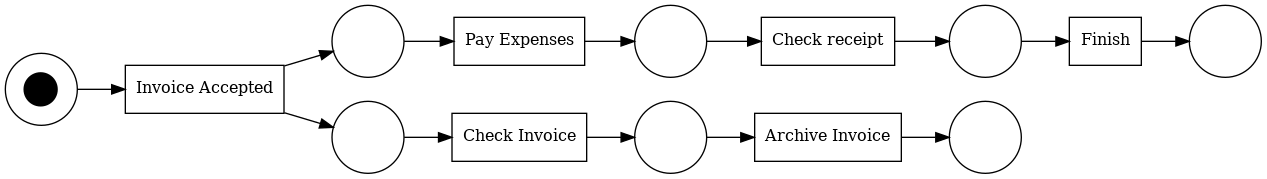

In [10]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking)
pn_visualizer.view(gviz)

In [11]:
parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, parameters=parameters)
pn_visualizer.save(gviz, "model_1.png")

### Create Reachability Graph

In [12]:

from pm4py.objects.petri_net.utils import reachability_graph

ts = reachability_graph.construct_reachability_graph(net, initial_marking)

In [13]:
for s in list(ts.states):
    print(s,s.incoming,s.outgoing)

2151 {Pay Expenses} {Check Invoice, Check receipt}
4171 {Archive Invoice, Finish} set()
1151 {Invoice Accepted} {Check Invoice, Pay Expenses}
1161 {Check Invoice} {Pay Expenses, Archive Invoice}
01 set() {Invoice Accepted}
2161 {Check Invoice, Pay Expenses} {Check receipt, Archive Invoice}
4161 {Finish, Check Invoice} {Archive Invoice}
2171 {Archive Invoice, Pay Expenses} {Check receipt}
4151 {Finish} {Check Invoice}
1171 {Archive Invoice} {Pay Expenses}
3161 {Check receipt, Check Invoice} {Finish, Archive Invoice}
3151 {Check receipt} {Check Invoice, Finish}
3171 {Check receipt, Archive Invoice} {Finish}


In [14]:
nodes,transitions={},{}
for t in ts.transitions:
    if str(t.from_state) in nodes:
        nodes[str(t.from_state)].append(str(t.name))
    else: 
        nodes[str(t.from_state)]=[str(t.name)]
    
    transitions[f"{t.from_state}#{t.name}"]=str(t.to_state)
    print(t.name,t.from_state,t.to_state)

Check Invoice 2151 2161
Pay Expenses 1151 2151
Check receipt 2161 3161
Invoice Accepted 01 1151
Finish 3151 4151
Check receipt 2151 3151
Archive Invoice 2161 2171
Check Invoice 3151 3161
Finish 3171 4171
Check Invoice 4151 4161
Archive Invoice 1161 1171
Check receipt 2171 3171
Archive Invoice 4161 4171
Pay Expenses 1161 2161
Archive Invoice 3161 3171
Pay Expenses 1171 2171
Check Invoice 1151 1161
Finish 3161 4161


In [15]:
nodes

{'2151': ['Check Invoice', 'Check receipt'],
 '1151': ['Pay Expenses', 'Check Invoice'],
 '2161': ['Check receipt', 'Archive Invoice'],
 '01': ['Invoice Accepted'],
 '3151': ['Finish', 'Check Invoice'],
 '3171': ['Finish'],
 '4151': ['Check Invoice'],
 '1161': ['Archive Invoice', 'Pay Expenses'],
 '2171': ['Check receipt'],
 '4161': ['Archive Invoice'],
 '3161': ['Archive Invoice', 'Finish'],
 '1171': ['Pay Expenses']}

In [16]:
transitions

{'2151#Check Invoice': '2161',
 '1151#Pay Expenses': '2151',
 '2161#Check receipt': '3161',
 '01#Invoice Accepted': '1151',
 '3151#Finish': '4151',
 '2151#Check receipt': '3151',
 '2161#Archive Invoice': '2171',
 '3151#Check Invoice': '3161',
 '3171#Finish': '4171',
 '4151#Check Invoice': '4161',
 '1161#Archive Invoice': '1171',
 '2171#Check receipt': '3171',
 '4161#Archive Invoice': '4171',
 '1161#Pay Expenses': '2161',
 '3161#Archive Invoice': '3171',
 '1171#Pay Expenses': '2171',
 '1151#Check Invoice': '1161',
 '3161#Finish': '4161'}

In [17]:
transitions['Start']=['01']
nodes['4171']=[]

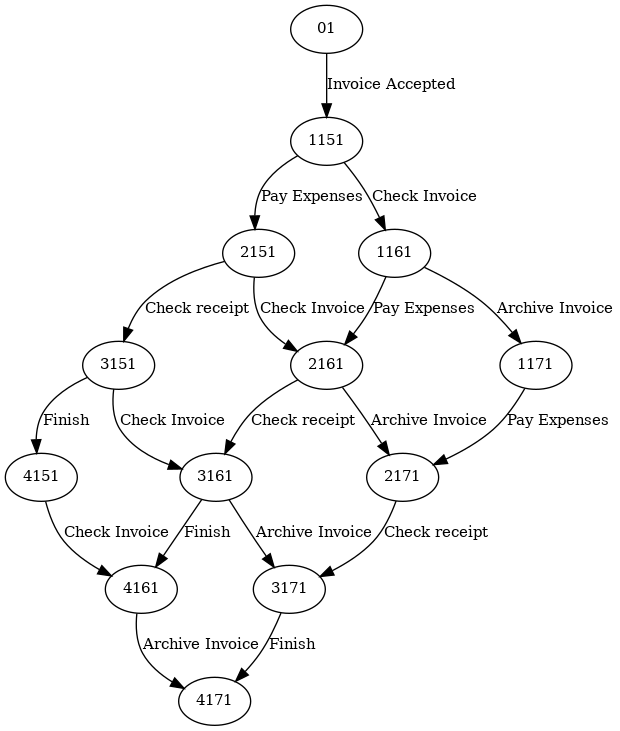

In [18]:
from pm4py.visualization.transition_system import visualizer as ts_visualizer

gviz = ts_visualizer.apply(ts)
ts_visualizer.view(gviz)

In [19]:
parameters = {ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT: "png"}
gviz = ts_visualizer.apply(ts, parameters=parameters)
pn_visualizer.save(gviz, "reach_graph_model_1.png")

### Simulate Event Logs

In [64]:
%%time

from pm4py.algo.simulation.playout.petri_net import algorithm as simulator

simulated_log = simulator.apply(net, initial_marking, variant=simulator.Variants.BASIC_PLAYOUT, parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 100000})

CPU times: user 19.8 s, sys: 160 ms, total: 19.9 s
Wall time: 19.9 s


In [65]:
%%time
from pm4py.objects.conversion.log import converter as log_converter
df = log_converter.apply(simulated_log, variant=log_converter.Variants.TO_DATA_FRAME)

CPU times: user 2.39 s, sys: 7.94 ms, total: 2.4 s
Wall time: 2.39 s


In [66]:
df

,concept:name,time:timestamp,case:concept:name
0,Invoice Accepted,1970-04-26 17:46:40,0
1,Check Invoice,1970-04-26 17:46:41,0
2,Archive Invoice,1970-04-26 17:46:42,0
3,Pay Expenses,1970-04-26 17:46:43,0
4,Check receipt,1970-04-26 17:46:44,0
...,...,...,...
599995,Pay Expenses,1970-05-03 16:26:35,99999
599996,Check receipt,1970-05-03 16:26:36,99999
599997,Finish,1970-05-03 16:26:37,99999
599998,Check Invoice,1970-05-03 16:26:38,99999


In [67]:
df.rename({'concept:name':'activity','case:concept:name':'trace_id','time:timestamp':'timestamp'},axis=1,inplace=True)

In [68]:
df.set_index('trace_id',inplace=True)

In [69]:
res=[]
for i,g in df.groupby(df.index):
    res.append([i,'Start'])
    for a in g['activity']:
        res.append([i,a])
df=pd.DataFrame(res,columns=['trace_id','activity'])
df

,trace_id,activity
0,0,Start
1,0,Invoice Accepted
2,0,Check Invoice
3,0,Archive Invoice
4,0,Pay Expenses
...,...,...
699995,99999,Pay Expenses
699996,99999,Check receipt
699997,99999,Finish
699998,99999,Check Invoice


In [70]:
df.set_index('trace_id',inplace=True)

In [71]:
df['event_id']=df.groupby(df.index).cumcount()

In [72]:
len(df.index.unique())

100000

<AxesSubplot:>

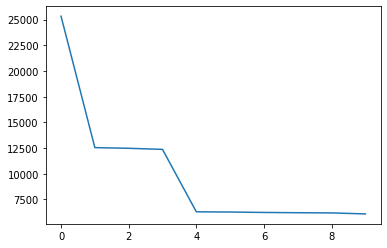

In [73]:
traces=df.groupby(df.index)['activity'].apply(lambda x:"->".join(list(x)))

traces = traces.value_counts()

traces.index = range(len(traces))

traces.plot()

## Deep Learning

In [74]:
from mppn.imports import *
from mppn.preprocessing import *
from mppn.pipeline import *
from mppn.baselines import *

In [75]:
seed = 99
splits = split_traces(df,validation_seed=seed,test_seed=seed)

In [76]:
o=PPObj(df,[Categorify()],cat_names=['activity'],y_names='activity',splits=splits)
o.show(max_n=2)
dls=o.get_dls(windows=partial(subsequences_fast,min_ws=0))
xcat,y=dls.one_batch()
xcat.shape,y.shape

#traces: 100000 #events: 700000


,activity
trace_id,
27288,7
27288,5


(torch.Size([64, 6]), torch.Size([64]))

In [77]:
class SimpleRNN(nn.Module):
    def __init__(self, o,cuda=True):
        super().__init__()
        n_hidden = 25
        vocab_size=len(o.procs.categorify['activity'])
        n_fac = int(sqrt(vocab_size))+1
        self.is_cuda=cuda
        self.n_hidden=n_hidden
        self.e = nn.Embedding(vocab_size,n_fac)
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden,vocab_size)
        
    def forward(self, xb):
        cs=xb.permute(1,0)
        bs = len(cs[0])
        h = torch.zeros((bs,self.n_hidden))
        if self.is_cuda: h=h.cuda()
        for c in cs:
            inp = torch.relu(self.l_in(self.e(c)))
            h = torch.tanh(self.l_hidden(h+inp))
        return F.log_softmax(self.l_out(h),dim=0)

In [78]:
class Camargo_specialized(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        emb_dim_act = int(sqrt(vocab_act))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)

        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)
    def forward(self, xcat):
        x_act = self.emb_act(xcat)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)

        return x_act

In [79]:
m=SimpleRNN(o,False)

In [80]:
m=Camargo_specialized(o)

In [81]:
p=m(xcat)

In [82]:
F.cross_entropy(p,y)

tensor(2.0821, grad_fn=<NllLossBackward>)

In [83]:
accuracy(p,y)

TensorBase(0.)

In [88]:
def fit_model(inp,prediction,nodes,transitions,v):
    prefix = inp.tolist()
    start=False
    curNode='01'
    for i in prefix:
        a = v[i]
        if a == 'Start':
            start=True
            continue
        if start:
            if a not in nodes[curNode]:
                raise ValueError('Prefix should be correct')
            curNode=transitions['#'.join([curNode,a])]
    # check prediction

    p = v[prediction]
    if p not in nodes[curNode]:
        return False
    return True






def model_check(inp,predictions,nodes,transitions,v):
    res=[]
    for i in range(len(inp)):
        res.append(fit_model(inp[i],predictions[i],nodes,transitions,v))
    return res

def plot_confusion_matrix_and_model_acc(m,color="light:b",pct=False):
    p=m(dls.valid_ds.inp[0].cuda())
    p=p.argmax(dim=1).cpu()

    y=dls.valid_ds.inp[1][0].cpu()

    def pct_cm(cm):
        m=np.zeros(cm.shape, dtype=float) 
        for i in range(len(cm[0])):
            summe=sum(cm[:,i])
            m[:,i]=(cm[:,i]/summe).round(2)
        return(m)



    pcm=confusion_matrix(y, p)
    if pct:
        pcm=pct_cm(pcm)
    
    vocab=o.categorify['activity'][y.unique().cpu().tolist()]

    cm_cols=o.categorify['activity'][np.unique(p.unique().cpu().tolist()+y.unique().cpu().tolist())]


   

    df_cm = pd.DataFrame(pcm, index = cm_cols,
                      columns = cm_cols)
    plt.figure(figsize = (7,7))
    sn.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap=sn.color_palette(color, as_cmap=True))
    plt.savefig("conf_matrix_model_1.png")

    x=dls.valid_ds.inp[0].cpu()
    x

    v=o.categorify['activity']

    res=model_check(x,p,nodes,transitions,v)
    print('model_acc',sum(res)/len(res))

In [85]:
x

array([[1, 1, 1, ..., 1, 1, 5],
       [1, 1, 1, ..., 1, 5, 2],
       [1, 1, 1, ..., 5, 2, 1],
       ...,
       [1, 1, 1, ..., 5, 6, 3],
       [1, 1, 1, ..., 6, 3, 2],
       [1, 1, 1, ..., 3, 2, 4]])

### Simple RNN

epoch,train_loss,valid_loss,accuracy,time
0,0.414539,0.397205,0.751938,01:04
1,0.418723,0.393462,0.757312,01:03
2,0.425074,0.394482,0.757604,01:02
3,0.419911,0.394337,0.757917,01:04


Better model found at epoch 0 with valid_loss value: 0.3972046673297882.
Better model found at epoch 1 with valid_loss value: 0.39346182346343994.
No improvement since epoch 0: early stopping


Better model found at epoch 0 with valid_loss value: 0.7593500018119812.


0.7593500018119812

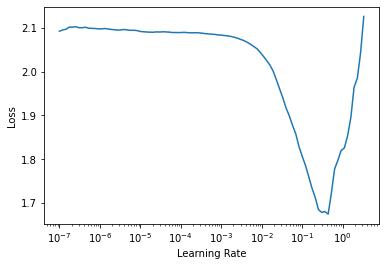

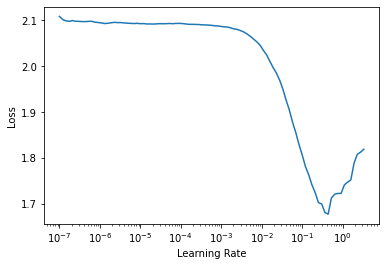

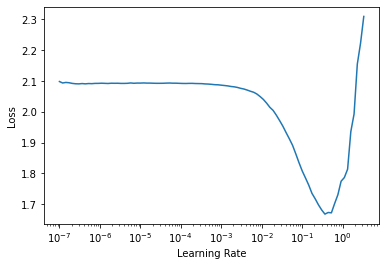

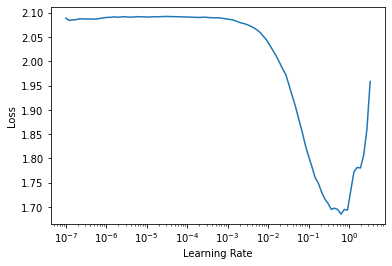

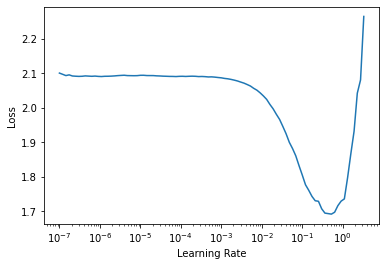

In [86]:
m1=SimpleRNN(o,True)
train_validate(dls,m1,loss=F.cross_entropy,metrics=accuracy,epoch=20,print_output=True)


model_acc 0.9773125


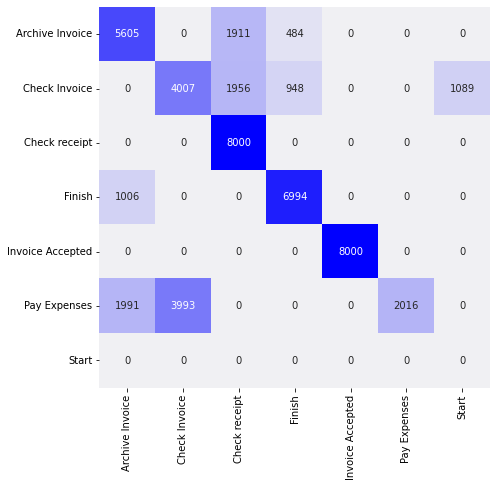

In [89]:
plot_confusion_matrix_and_model_acc(m1)

### Camargo Specialized

epoch,train_loss,valid_loss,accuracy,time
0,1.611564,1.607340,0.666667,00:57
1,1.536823,1.531356,0.742667,00:57
2,1.702474,1.596357,0.677750,00:55
3,1.745426,1.831286,0.518792,00:58
4,2.104797,2.107350,0.166667,00:56


Better model found at epoch 0 with valid_loss value: 1.6073402166366577.
Better model found at epoch 1 with valid_loss value: 1.5313557386398315.
No improvement since epoch 1: early stopping


Better model found at epoch 0 with valid_loss value: 0.7400916814804077.


0.7400916814804077

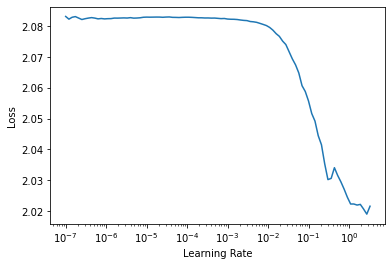

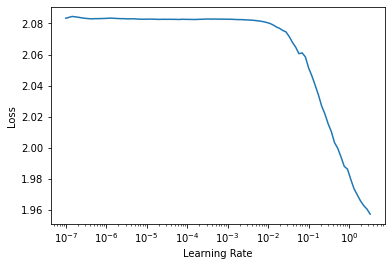

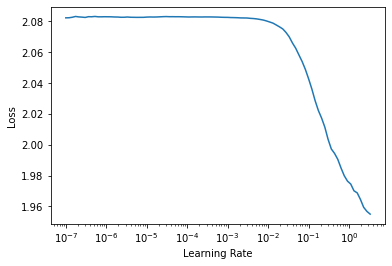

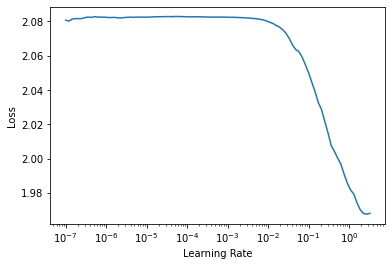

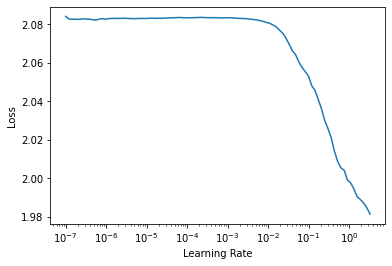

In [90]:
m2=Camargo_specialized(o)
train_validate(dls,m2,loss=F.cross_entropy,metrics=accuracy,epoch=20,print_output=True)


model_acc 1.0


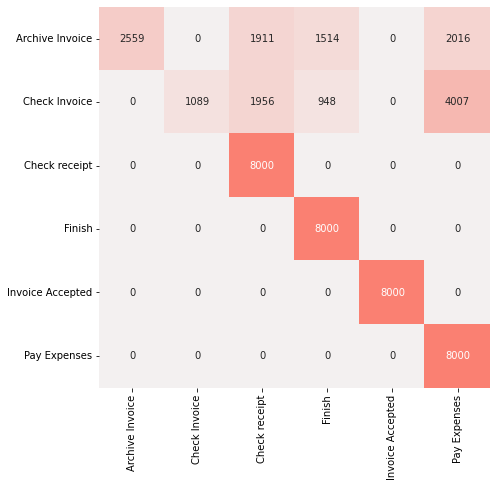

In [91]:
plot_confusion_matrix_and_model_acc(m2,'light:salmon')

### MPPN

In [92]:
from mppn.mppn import *

In [93]:
# add cost attribute that does nothing because MPPN requires at least 2 attributes
# Todo: fix hack
cost = np.random.normal(loc=400,scale=350,size=len(df)).round(2)
cost = cost.clip(0)
df['cost'] = cost

In [94]:
def mppn_get_output_attributes(o):
    output_attributes = {i:len(o.procs.categorify[i]) for i in o.ycat_names }
    for i in o.ycont_names: output_attributes[i]=1
    return output_attributes

Loading Alexnet to train MPPNs CNN from scratch


epoch,train_loss,valid_loss,accuracy,time
0,0.358017,0.361914,0.738458,02:56
1,0.356919,0.362659,0.738896,02:58
2,0.379740,0.448626,0.727875,02:57
3,0.383007,0.361429,0.741000,02:56


Better model found at epoch 0 with valid_loss value: 0.36191365122795105.
No improvement since epoch 0: early stopping


Better model found at epoch 0 with valid_loss value: 0.7387833595275879.


0.7387833595275879

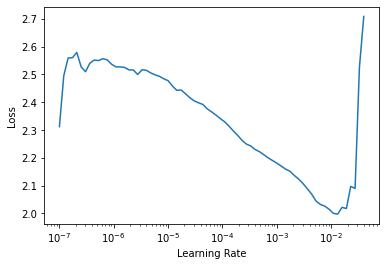

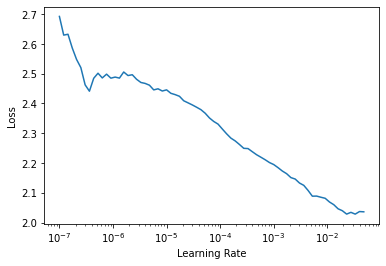

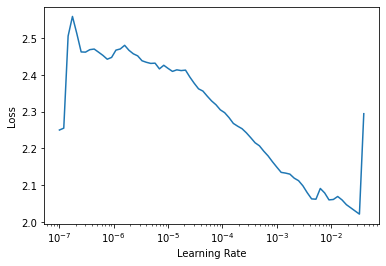

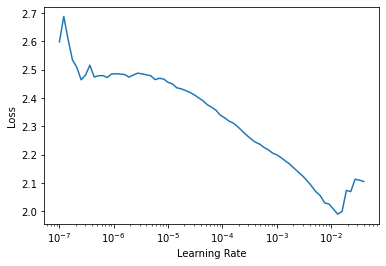

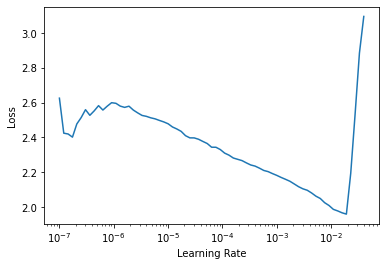

In [95]:
o=PPObj(df,[Categorify,Datetify,FillMissing,MinMax],
        cat_names=['activity'],cont_names=['cost'],
        splits=splits,y_names=['activity'])
output_attributes=mppn_get_output_attributes(o)
col='activity'
m3 = mppn_representation_learning_model(False, len(o.cont_names), output_attributes)
m3 = mppn_fine_tuning_model(m3, len(output_attributes), output_attributes[col])

dls=o.get_dls(after_batch=gaf_transform,windows=partial(subsequences_fast),bs=32)
train_validate(dls,m3,loss=F.cross_entropy,metrics=accuracy,epoch=20)

<AxesSubplot:>

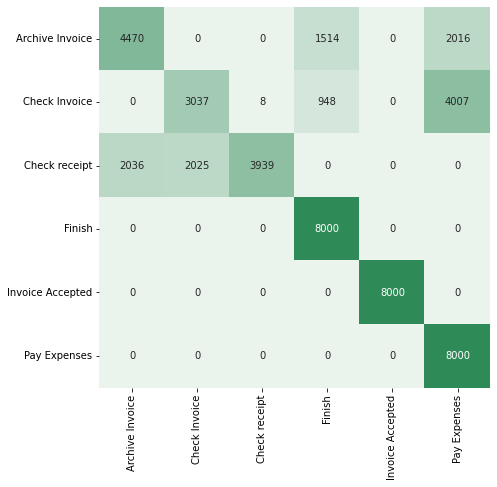

In [96]:
m =  m3.cuda()
ps,ys=[],[]
for b in dls.valid:  
    p=m(b[0].cuda())
    p=p.argmax(dim=1).cpu()
    y=b[1].cpu()
    ps+=p.tolist()
    ys+=y.tolist()
color= 'light:seagreen'
p,y =tensor(ps),tensor(ys)
cm=confusion_matrix(y, p)
pcm=cm
#pcm=pct_cm(cm)

o.categorify['activity'][y.unique().cpu().tolist()]

vocab=o.categorify['activity'][y.unique().cpu().tolist()]



cm_cols=o.categorify['activity'][np.unique(p.unique().cpu().tolist()+y.unique().cpu().tolist())]


df_cm = pd.DataFrame(pcm, index = cm_cols,
                  columns = cm_cols)
plt.figure(figsize = (7,7))
sn.heatmap(df_cm, fmt='g',annot=True,cbar=False, cmap=sn.color_palette(color, as_cmap=True)
)



In [97]:
x=dls.valid_ds.inp[0][:,0].cpu().numpy()
minn, maxx = o.min_max.mins['activity'],o.min_max.maxs['activity']
x = x*(maxx-minn) +minn
x=x.astype(int)
v=o.categorify['activity']



In [98]:
res=model_check(x,p,nodes,transitions,v)
print('model_acc',sum(res)/len(res))

model_acc 1.0


In [50]:
inp = [
    [0.7735833525657654,0.9893958333333334],
    [0.739425003528595,1.0],
    [0.7399666905403137,1.0],
    
]
print(pd.DataFrame(inp,columns=['Net-step Accuracy','Model Assessment'],index=['Simple RNN','Camargo Specialiced','MPPN']).round(3).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Net-step Accuracy &  Model Assessment \\
\midrule
Simple RNN          &              0.774 &             0.989 \\
Camargo Specialiced &              0.739 &             1.000 \\
MPPN                &              0.740 &             1.000 \\
\bottomrule
\end{tabular}

